In [37]:
#pip install meshlabxml

In [38]:
#pip install open3d

In [39]:
#pip install Pillow

In [40]:
import numpy as np
import cv2 as cv
import os
import glob
import open3d as op3
from tqdm import tqdm
from matplotlib import pyplot as plt

In [41]:
def smoothing(disparity):
    new_disparity = disparity.copy()
    for i in range(disparity.shape[0]):
        for j in range(disparity.shape[1]):
            new_color=disparity[i][j]
            if new_color<0 :
                counter=0
            while new_color==disparity[i][j]:
                if i+counter>disparity.shape[0] and j+counter>disparity.shape[1]:
                    break
                if i-counter>0:
                    if disparity[i-counter][j]>60:
                        new_color=disparity[i-counter][j]
                        break
                if i+counter<disparity.shape[0]:
                    if disparity[i+counter][j]>60:
                        new_color=disparity[i+counter][j]
                        break
                if j-counter>0:
                    if disparity[i][j-counter]>60:
                        new_color=disparity[i][j-counter]
                        break
                if j+counter<disparity.shape[1]:
                    if disparity[i][j+counter]>60: 
                        new_color=disparity[i][j+counter]
                        break
                counter+=1
            new_disparity[i][j]=new_color
    return new_disparity

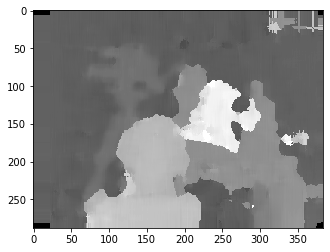

In [42]:
img_R = cv.imread('./imagenes/ImgR.jpeg',0)
img_L = cv.imread('./imagenes/ImgL.jpeg',0)
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img_L,img_R)
disparity_ = smoothing(disparity)
plt.imshow(disparity_,'gray')
plt.show()

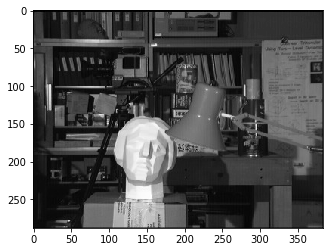

In [43]:
plt.imshow(img_R,'gray')
plt.show()

In [44]:
ret = np.load('./camera_params/ret.npy')
K = np.load('./camera_params/K.npy')
dist = np.load('./camera_params/dist.npy')
focal_length = np.load('./camera_params/FocalLength.npy')
h,w = img_L.shape[:2]

In [45]:
h,w

(288, 384)

In [46]:
focal_length

array(3.99)

In [47]:
dist

array([[ 0.21977968, -1.19558502,  0.00243337, -0.00432391,  1.77534627]])

In [48]:
K

array([[3.30372598e+03, 0.00000000e+00, 1.48216720e+03],
       [0.00000000e+00, 3.39642612e+03, 1.98711945e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Camara matrix

In [49]:
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [50]:
h,w = img_L.shape[:2]

Q = np.float32([[1,0,0,0],
                 [0,-1,0,0],
                 [0,0,focal_length*0.05,0],
                 [0,0,0,1]])

points_3D = cv.reprojectImageTo3D(disparity_, Q)
img_color = cv.imread('./imagenes/ImgL.jpeg')
colors = cv.cvtColor(img_color, cv.COLOR_BGR2RGB)
mask_map = disparity_ > disparity_.min()
output_points = points_3D[mask_map]
output_colors = colors[mask_map]
output_file = 'remaster.ply'
create_output(output_points, output_colors, output_file)

In [51]:
pcd = op3.io.read_point_cloud("remaster.ply")
op3.visualization.draw_geometries([pcd])